# How to identify groups of articles relevant to a specific news event

Here we provide a demo of the temporal community detection procedure applied to an example event. The approach collects the groups of articles that are both well connected and exhibit similar patterns of page views to some specified seed articles.

Note that data collection is not performed from scratch in this demo version, but the doc will be updated.

In [1]:
import pandas as pd
from nodeprocess import *

## 1. Data collection

N.B. This section incomplete at present and does not collect data from scratch.

Take a sample event with hyperlinked Wikipedia articles and an event date. e.g.:

_2018/11/30 ___[2018 Anchorage earthquake](https://en.wikipedia.org/wiki/2018_Anchorage_earthquake)___: A ___[magnitude](https://en.wikipedia.org/wiki/Moment_magnitude_scale)___ 7.0 earthquake hits Alaska, with the epicenter in ___[Anchorage](https://en.wikipedia.org/wiki/Anchorage,_Alaska)___. Severe damage is reported._

In [2]:
# Pre-collected data, will be updated to collect from scratch
edgelist = pd.read_csv('demo_data/edgelist.csv')
display(edgelist.head())

,prev,curr,n
0,1556_Shaanxi_earthquake,Lists_of_earthquakes,1
1,1556_Shaanxi_earthquake,Seismic_magnitude_scales,1
2,1700_Cascadia_earthquake,1906_San_Francisco_earthquake,1
3,1700_Cascadia_earthquake,2004_Indian_Ocean_earthquake_and_tsunami,1
4,1700_Cascadia_earthquake,List_of_earthquakes_in_the_United_States,1


In [3]:
timeseries = pd.read_csv('demo_data/timeseries_scaled.csv',  index_col=0)
display(timeseries.head())

,1556_Shaanxi_earthquake,1693_Sicily_earthquake,1700_Cascadia_earthquake,1755_Lisbon_earthquake,1857_Fort_Tejon_earthquake,1886_Charleston_earthquake,1906_San_Francisco_earthquake,1908_Messina_earthquake,1925_serum_run_to_Nome,1946_Aleutian_Islands_earthquake,...,"Wasilla,_Alaska",We_Are_the_World,We_Are_the_World_25_for_Haiti,West_Coast_of_the_United_States,Western_Collegiate_Hockey_Association,White_Americans,"Whittier,_Alaska",William_H._Seward,Winter_solstice,Yup'ik
2018-10-31,-0.116071,0.1250,0.250000,4.317647,0.939394,-0.09375,-0.018443,0.063830,0.105263,0.333333,...,-0.451220,-1.124733,-1.523077,0.502242,-0.677419,0.650316,-0.389671,-0.075099,-0.401140,0.105263
2018-11-01,-0.258929,1.0625,0.046296,12.147059,-0.303030,-0.06250,-0.350410,0.000000,-1.065789,0.119048,...,-0.329268,-0.874200,-0.830769,0.336323,-0.532258,1.313291,-0.323944,-0.367589,-0.406620,0.578947
2018-11-02,-0.383929,0.9375,-0.157407,3.547059,0.575758,0.50000,-0.127049,-0.510638,-0.460526,-0.452381,...,-0.780488,-0.310235,0.200000,0.408072,-0.290323,1.881329,-0.316901,-0.181818,-0.425910,-0.421053
2018-11-03,-1.008929,-0.1875,-0.592593,0.882353,-0.545455,-0.03125,-0.573770,-0.702128,-1.223684,-0.857143,...,-0.475610,0.490405,0.461538,-0.695067,1.629032,4.045886,-0.356808,-0.604743,-0.465585,0.789474
2018-11-04,-0.642857,-0.1875,-0.333333,0.800000,0.272727,1.96875,-0.514344,-0.808511,-0.618421,-0.857143,...,-0.365854,1.125800,1.215385,-0.170404,1.258065,1.344937,-0.356808,-0.474308,-0.300526,-0.263158


## 2. Processing

Pre-process network and pageview data

In [4]:
# Convert to undirected adjacency matrix (undirected only for demo, not strictly necesssary)
articles = sorted(set(edgelist['prev']) | set(edgelist['curr']))
network = (~edgelist.pivot(index='prev', columns='curr', values='n').isna()
               ).reindex(columns=articles, index=articles, fill_value=False)
network = (network | network.T).astype(int)

In [5]:
# Optional, create another network, where edges may change at each timestep.
# Change random indices to do this here. Clearly you would want to use a real
# temporal network if doing this for real

# import random
# tnetwork = np.array(61*[network])
# random_indexs = [(random.randint(0, 60), random.randint(0, 442), random.randint(0, 442)) for _ in range(1000)]
# for r in random_indexs:
#     tnetwork[*r] = 0
# random_indexs = [(random.randint(0, 60), random.randint(0, 442), random.randint(0, 442)) for _ in range(1000)]
# for r in random_indexs:
#     tnetwork[*r] = 1

## 3. Community detection

Supply network and page view data to temporal community detection algorithm. The algorithm identifies groups of articles that are both well connected and exhibit similar attention dynamics around the time of the event.

In [6]:
window_size = 7
membership_df = community_detection(timeseries, network, window_size=window_size, res=0.25, tau=1)
# Or use the network which may change at each timestep:
# membership_df = community_detection(timeseries, tnetwork, window_size=window_size, res=0.25, tau=1, nodenames=network.columns)

/Users/Patrick/Documents/LSE/Projects/nodeprocess/nodeprocess.py:28: RuntimeWarning: invalid value encountered in divide
  xmn = xm/np.sqrt((xm*xm).sum(axis=0))


In [7]:
core = ['2018_Anchorage_earthquake', 'Moment_magnitude_scale', 'Anchorage,_Alaska']
date = timeseries.index[30]

# get community of specific article on date
article = core[0]
community = membership_df.loc[article, date]
in_community = membership_df[membership_df==community].notna().any(axis=1)

# get all articles in community
community_articles = (membership_df[in_community]==community)

print(community)
display(community_articles.head())

84


,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,...,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27
1556_Shaanxi_earthquake,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1700_Cascadia_earthquake,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1755_Lisbon_earthquake,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1906_San_Francisco_earthquake,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,True,True,False,False
1908_Messina_earthquake,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 4. Plotting

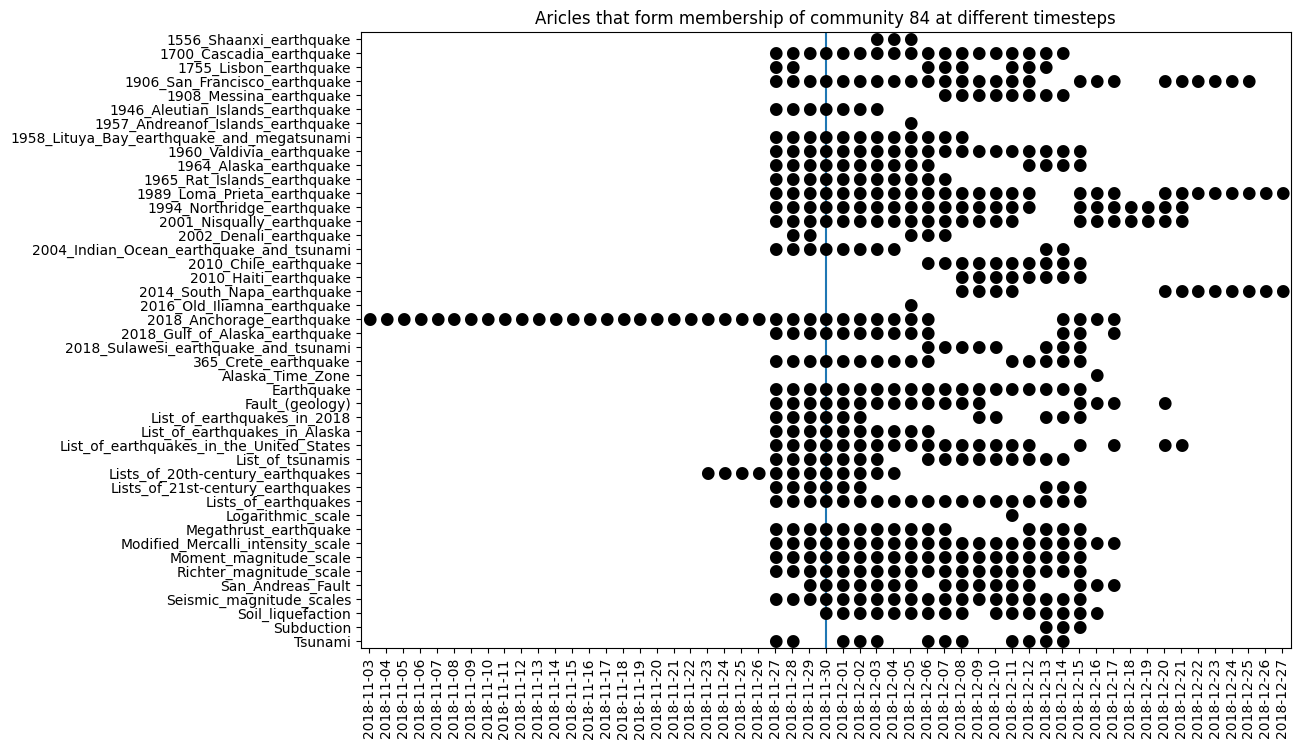

In [9]:
import matplotlib.pyplot as plt

# Plot articles in community at each timestep

# Plotting
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xticks(range(len(community_articles.columns)))
ax.set_xticklabels(community_articles.columns)
ax.set_yticks(range(len(community_articles.index)))
ax.set_yticklabels(community_articles.index)

# Loop through DataFrame and add dots where the value is True
for i in range(len(community_articles.index)):
    for j in range(len(community_articles.columns)):
        if community_articles.iloc[i, j]:
            ax.text(j, i, '●', ha='center', va='center', fontsize=12)

# add line at event date
ax.axvline(list(community_articles.columns).index(date))

# Remove grid lines
ax.grid(False)

# Set the limits
ax.set_ylim(-0.5, len(community_articles.index)-0.5)
ax.set_xlim(-0.5, len(community_articles.columns)-0.5)

# Rotate x tick labels
ax.tick_params(axis='x', labelrotation=90)

ax.set_title('Aricles that form membership of community %d at different timesteps' %community)

# Display the plot
ax.invert_yaxis()
plt.show()


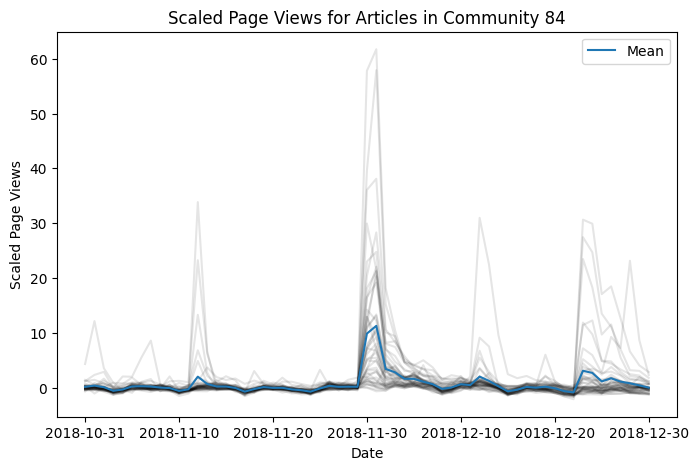

In [10]:
community_ts = timeseries[in_community[in_community].index]
fig, ax = plt.subplots(figsize=(8,5))
community_ts.plot(c='k', legend=False, alpha=0.1, ax=ax)
community_ts.mean(axis=1).plot(ax=ax, label='Mean')
h, l = ax.get_legend_handles_labels()
ax.legend(h[-1:], l[-1:])
ax.set_ylabel('Scaled Page Views')
ax.set_xlabel('Date')
ax.set_title('Scaled Page Views for Articles in Community %d' %community)
xt = ax.get_xticks()
xtl = ax.get_xticklabels()
xlim = ax.get_xlim()

Text(0.5, 1.0, 'Scaled Page Views for Articles in Community 84\nwhile part of community')

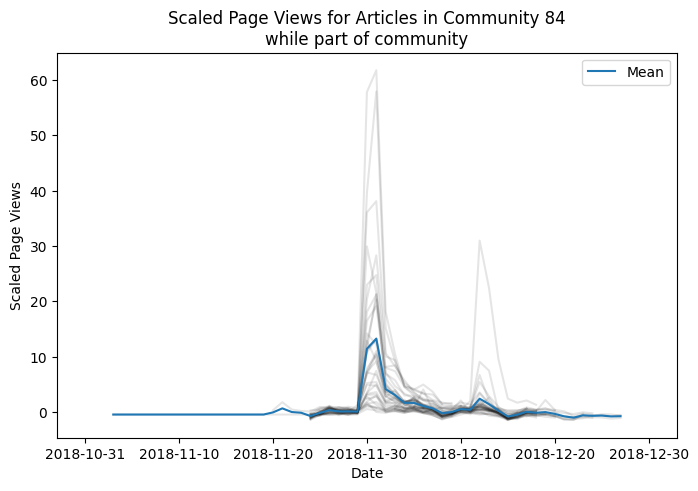

In [11]:
offset = window_size//2

filldf = community_articles.replace(False, np.nan
                    ).bfill(limit=offset, axis=1
                    ).ffill(limit=(window_size-1)-offset, axis=1).T # also plot previous/next timesteps that form pearson corr

fig, ax = plt.subplots(figsize=(8,5))
community_ts[filldf].plot(c='k', legend=False, alpha=0.1, ax=ax)
community_ts[filldf].mean(axis=1).plot(ax=ax, label='Mean')
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.set_xlim(xlim)
h, l = ax.get_legend_handles_labels()
ax.legend(h[-1:], l[-1:])
ax.set_ylabel('Scaled Page Views')
ax.set_xlabel('Date')
ax.set_title('Scaled Page Views for Articles in Community %d\nwhile part of community' %community)